<a href="https://colab.research.google.com/github/jamiewu128/AIA_Example/blob/master/ToDo_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://jamiewu128@bitbucket.org/jamiewu128/todo_prediction.git

Cloning into 'todo_prediction'...
remote: Counting objects: 26, done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 10), reused 0 (delta 0)
Unpacking objects: 100% (26/26), done.


In [0]:
cd /content/todo_prediction/

/content/todo_prediction


In [0]:
!git pull

remote: Counting objects: 4, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0)
Unpacking objects: 100% (4/4), done.
From https://bitbucket.org/jamiewu128/todo_prediction
   2c36b53..4a084c8  master     -> origin/master
Updating 2c36b53..4a084c8
Fast-forward
 dict.txt                  |   2 +-
 noto_sans_cjk_regular.otf | Bin 0 -> 16431292 bytes
 2 files changed, 1 insertion(+), 1 deletion(-)
 create mode 100644 noto_sans_cjk_regular.otf


In [0]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
import jieba
from gensim.models import word2vec
import seaborn as sns
from matplotlib.font_manager import FontProperties

In [0]:
myfont = FontProperties(fname='/content/todo_prediction/noto_sans_cjk_regular.otf')

#出勤刷卡記錄

In [0]:
sheetName=['人員資料','201903-201905']
yearsInCompany=pd.read_excel('/content/todo_prediction/attendance.xlsx', sheet_name=sheetName[0],index_col=None)
attendLog=pd.read_excel('/content/todo_prediction/attendance.xlsx', sheet_name=sheetName[1], index_col=None)

In [0]:
print(yearsInCompany.head(30))
print(attendLog.head(20))

          工號   姓名   服務年資
0   01000073  周欣伶  18.92
1   01090191  游靜宜   9.06
2   01100090  王俊程   9.04
3   01120216  林相宇   6.68
4   01140045  郭俊宏   4.70
5   01150023  林哲如   4.11
6   01150034  曾聖瑋   4.04
7   01150038  許育瑞   3.98
8   01160047  吳家珍   2.82
9   01160059  高立蕎   2.66
10  01160082  吳紀臻   2.60
11  01170002  王威授   2.44
12  01170004  賴慶聰   2.41
13  01170009  許維德   2.35
14  01170064  鄭祐真   1.83
15  01180003  王傳瑋   1.39
16  01180024  陳炳璋   1.18
17  01190051  王百川   0.08
18  G2140005  曾士瑋   5.32
19  G2140009  劉冠廷   5.20
20  J1120003  葉啟章   7.12
          工號   姓名          門禁卡號                     刷卡時間
0   01000073  周欣伶  138100007310  2019-03-04 13:59:22.000
1   01000073  周欣伶  138100007310  2019-03-04 13:59:40.000
2   01000073  周欣伶  138100007310  2019-03-04 16:46:04.000
3   01000073  周欣伶  138100007310  2019-03-04 16:50:05.000
4   01000073  周欣伶  138100007310  2019-03-04 20:19:25.000
5   01000073  周欣伶  138100007310  2019-03-04 20:19:41.000
6   01000073  周欣伶  138100007310  2019-03-05 09:51:2

In [0]:
employee_id = yearsInCompany['工號']
date_time_str = attendLog['刷卡時間']


#date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')

In [0]:
date_time_obj0 = datetime.datetime.strptime(date_time_str[0], '%Y-%m-%d %H:%M:%S.%f')
date_time_obj1 = datetime.datetime.strptime(date_time_str[7], '%Y-%m-%d %H:%M:%S.%f')

In [0]:
date_list=[]
hour_list=[]
min_list=[]
date_all_list=[]
weekday_list=[]
for d in date_time_str:
  dt=datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f')
  date_list.append(dt.date())
  hour_list.append(dt.hour)
  min_list.append(dt.minute)
  weekday_list.append(dt.weekday()+1)
  date_all_list.append(dt)
  
  
attend_df=pd.DataFrame({
    'id':attendLog['工號'],
    'name':attendLog['姓名'],
    'card_number':attendLog['門禁卡號'],
    'date':date_list,
    'hour':hour_list,
    'minute':min_list,
    'weekday':weekday_list,
    'datetime':attendLog['刷卡時間']})
  

In [0]:
attend_df.head(10)

,id,name,card_number,date,hour,minute,weekday,datetime
0,01000073,周欣伶,138100007310,2019-03-04,13,59,1,2019-03-04 13:59:22.000
1,01000073,周欣伶,138100007310,2019-03-04,13,59,1,2019-03-04 13:59:40.000
2,01000073,周欣伶,138100007310,2019-03-04,16,46,1,2019-03-04 16:46:04.000
3,01000073,周欣伶,138100007310,2019-03-04,16,50,1,2019-03-04 16:50:05.000
4,01000073,周欣伶,138100007310,2019-03-04,20,19,1,2019-03-04 20:19:25.000
5,01000073,周欣伶,138100007310,2019-03-04,20,19,1,2019-03-04 20:19:41.000
6,01000073,周欣伶,138100007310,2019-03-05,9,51,2,2019-03-05 09:51:25.000
7,01000073,周欣伶,138100007310,2019-03-05,16,48,2,2019-03-05 16:48:35.000
8,01000073,周欣伶,138100007310,2019-03-05,16,49,2,2019-03-05 16:49:32.000
9,01000073,周欣伶,138100007310,2019-03-05,20,19,2,2019-03-05 20:19:39.000


In [0]:
attend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8255 entries, 0 to 8254
Data columns (total 8 columns):
id             8255 non-null object
name           8255 non-null object
card_number    8255 non-null int64
date           8255 non-null object
hour           8255 non-null int64
minute         8255 non-null int64
weekday        8255 non-null int64
datetime       8255 non-null object
dtypes: int64(4), object(4)
memory usage: 516.0+ KB


(array([  27.,    0.,    0., 1450., 1309., 1779., 1738.,  899.,  834.,
         219.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

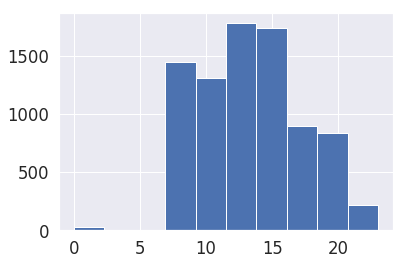

In [0]:
plt.hist(attend_df['hour'])

In [0]:
attend_df[attend_df.hour<6]

,id,name,card_number,date,hour,minute,weekday,datetime
489,01090191,游靜宜,138109019110,2019-05-03,1,13,5,2019-05-03 01:13:23.000
1347,01100090,王俊程,138110009020,2019-05-24,0,19,5,2019-05-24 00:19:17.000
1348,01100090,王俊程,138110009020,2019-05-24,0,32,5,2019-05-24 00:32:28.000
3357,01160059,高立蕎,138116005910,2019-04-01,1,2,1,2019-04-01 01:02:04.000
3358,01160059,高立蕎,138116005910,2019-04-01,1,2,1,2019-04-01 01:02:08.000
3359,01160059,高立蕎,138116005910,2019-04-01,1,10,1,2019-04-01 01:10:31.000
3360,01160059,高立蕎,138116005910,2019-04-01,1,11,1,2019-04-01 01:11:52.000
3488,01160059,高立蕎,138116005910,2019-05-03,1,13,5,2019-05-03 01:13:24.000
4648,01170004,賴慶聰,138117000410,2019-04-29,0,38,1,2019-04-29 00:38:01.000
4666,01170004,賴慶聰,138117000410,2019-05-02,1,18,4,2019-05-02 01:18:52.000


###計算有加班情形的記錄

In [0]:
employId=attend_df['id'].unique()
#print(employId)
my_cols=['id','name','hour','datetime']
id_ls=[]
name_ls=[]
hour_ls=[]
weekday_ls=[]
dtime_ls=[]
for employ in employId:
  temp_df=attend_df[attend_df.id==employ]
  temp_df=temp_df[(temp_df.hour<6) | (temp_df.hour>=20) | (temp_df.weekday>=6)]#晚上8點後離開 或 星期六日到公司
  for i in range(len(temp_df)):
    id_ls.append(temp_df['id'].iloc[i])
    name_ls.append(temp_df['name'].iloc[i])
    hour_ls.append(temp_df['hour'].iloc[i])
    weekday_ls.append(temp_df['weekday'].iloc[i])
    dtime_ls.append(temp_df['datetime'].iloc[i])
  
over_df=pd.DataFrame({'id':id_ls,'name':name_ls,'hour':hour_ls,'weekday':weekday_ls,'datetime':dtime_ls})
print(len(over_df))
over_df.head()


582


,id,name,hour,weekday,datetime
0,01000073,周欣伶,20,1,2019-03-04 20:19:25.000
1,01000073,周欣伶,20,1,2019-03-04 20:19:41.000
2,01000073,周欣伶,20,2,2019-03-05 20:19:39.000
3,01000073,周欣伶,20,2,2019-03-05 20:19:55.000
4,01000073,周欣伶,20,3,2019-03-06 20:21:08.000


###計算每一員工在辦公室的停留時數

In [0]:
id_list=[]
name_list=[]
date_list=[]
date_str_list=[]
work_hour_list=[]
# every employee
for _id in employee_id:
  emp=attend_df[attend_df.id==_id]
  date_u=emp['date'].unique()
  
  # by date
  for _date in date_u:
    emp_d=emp[emp.date==_date]
    emp_d_len=len(emp_d)
    date0_str=emp_d.head(1)['datetime']
    name=emp_d.head(1)['name']
    
    #print(emp_datetime)
    #print(type(emp_datetime))
    #print('date:',_date,'  len:',emp_d_len)
    id_list.append(_id)
    name_list.append(name.iloc[0])
    date_list.append(_date)
    date_str_list.append(date0_str.iloc[0])
    
    if emp_d_len>1:
      
      date1_str=emp_d.tail(1)['datetime']
      #print('date0:',date0_str)
      #print('date1:',date1_str)
      
      date0=datetime.datetime.strptime(date0_str.iloc[0], '%Y-%m-%d %H:%M:%S.%f')
      date1=datetime.datetime.strptime(date1_str.iloc[0], '%Y-%m-%d %H:%M:%S.%f')
    
      dateDiff=date1-date0
      DiffInHours=dateDiff.total_seconds() / 3600
      #print('DiffInHours: ',DiffInHours)
      work_hour_list.append(DiffInHours)
      
    elif emp_d_len==1:
      # TODO : work over night ?
      #print('date: ',date0_str.iloc[0],' ',name)
      work_hour_list.append(0)
      
      
df_wh=pd.DataFrame({'id':id_list,'name':name_list,'date':date_list,'work_hour':work_hour_list, 'date_str':date_str_list})
df_wh.head()

,id,name,date,work_hour,date_str
0,01000073,周欣伶,2019-03-04,6.338611,2019-03-04 13:59:22.000
1,01000073,周欣伶,2019-03-05,10.475000,2019-03-05 09:51:25.000
2,01000073,周欣伶,2019-03-06,10.575000,2019-03-06 09:46:51.000
3,01000073,周欣伶,2019-03-07,9.683611,2019-03-07 09:49:00.000
4,01000073,周欣伶,2019-03-08,8.768889,2019-03-08 09:46:28.000


(array([ 38.,  38.,  71., 291., 550.,  93.,  20.,   1.,   7.,   2.]),
 array([ 0.        ,  2.29886111,  4.59772222,  6.89658333,  9.19544444,
        11.49430556, 13.79316667, 16.09202778, 18.39088889, 20.68975   ,
        22.98861111]),
 <a list of 10 Patch objects>)

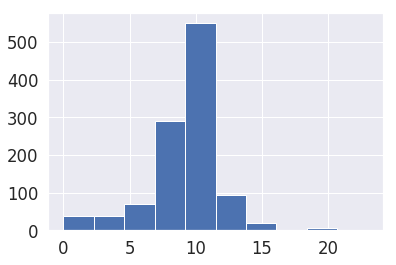

In [0]:
hours=df_wh['work_hour']
plt.hist(hours)

In [0]:
wh0=df_wh[df_wh.work_hour==0]
wh1=df_wh[df_wh.work_hour>8]
wh1_1=wh1[wh1.work_hour<10]
print(len(df_wh))
print(len(wh0))
print(len(wh1_1))

1111
13
537


#ToDo資料

##ToDo清單

In [0]:
xtree = et.parse('/content/todo_prediction/Todo_detail.xml')
xroot = xtree.getroot()
df_cols = [
"ID",
"Title",
"AccountID",
"Username",
"DisplayName",
"TodoStatus",
"GroupID",
"GroupName",
"GroupEnabled",
"GroupLevel",
"RootToDoID",
"ParentToDoID",
"ParentAccountID",
"Progress",
"LastProgress",
"AlertType",
"ProgressUpdateTime",
"Description",
"HasDueTime",
"CreatedDateTime",
"LastUpdatedDateTime",
"StartDateTime",
"DueDateTime"]
out_df = pd.DataFrame(columns = df_cols)

for node in xroot:
  col_values = []
  for col_name in df_cols:
    col_values.append(node.attrib.get(col_name))
  out_df = out_df.append(pd.Series(col_values, index = df_cols), ignore_index=True)

out_df.head(100)

,ID,Title,AccountID,Username,DisplayName,TodoStatus,GroupID,GroupName,GroupEnabled,GroupLevel,RootToDoID,ParentToDoID,ParentAccountID,Progress,LastProgress,AlertType,ProgressUpdateTime,Description,HasDueTime,CreatedDateTime,LastUpdatedDateTime,StartDateTime,DueDateTime
0,12204,FCM 移轉,2443,belltseng,Bell,0,1591,APD每週例會報告,1,6,None,None,None,100,50,1,2019-03-14T04:14:41.730,,0,2019-02-01T00:31:31.950,2019-03-14T04:14:41.730,2019-02-01T00:31:00,2019-03-31T15:59:59
1,12205,iOS,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12204,12204,2443,100,15,1,2019-03-14T02:39:35.197,,0,2019-02-01T00:32:14.637,2019-03-14T02:40:11.113,2019-02-01T00:32:00,2019-03-29T15:59:59
2,12206,Android,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12204,12204,2443,100,100,1,2019-03-14T04:14:41.450,,0,2019-02-01T00:32:38.097,2019-03-19T01:54:43.567,2019-02-01T00:32:00,2019-03-29T15:59:59
3,12207,teamup! 90 優化-ios,2443,belltseng,Bell,0,1591,APD每週例會報告,1,6,None,None,None,100,1,1,2019-04-01T06:37:38.160,,0,2019-02-01T01:09:17.507,2019-04-01T06:37:38.160,2019-02-01T01:09:00,2019-03-31T15:59:59
4,12208,iOS 貼文回覆延申 bar UI,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-15T00:07:15.643,,0,2019-02-01T01:09:55.470,2019-03-08T00:36:57.803,2019-02-01T01:09:00,2019-02-14T15:59:59
5,12209,Android 貼文回覆延申 bar U,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-15T00:26:24.507,,0,2019-02-01T01:10:26.557,2019-02-22T01:44:20.657,2019-02-01T01:10:00,2019-02-14T15:59:59
6,12210,iOS 通知迷航,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-27T09:22:24.640,,0,2019-02-01T01:11:01.293,2019-02-27T09:22:27.280,2019-02-01T01:11:00,2019-02-21T15:59:59
7,12211,Android 通知迷航,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-03-14T02:51:58.220,,0,2019-02-01T01:11:20.380,2019-03-14T02:54:37.803,2019-02-01T01:11:00,2019-02-21T15:59:59
8,12222,AJA pdf 03 評分調整,2193,hsiangyulin,Hsiangyu Lin,1,1591,APD每週例會報告,1,6,12062,12062,2193,100,10,1,2019-02-22T09:20:38.297,,0,2019-02-14T02:35:33.180,2019-03-11T03:08:13.673,2019-02-14T02:35:00,2019-02-22T15:59:59
9,12223,搜索工作,2193,hsiangyulin,Hsiangyu Lin,1,1591,APD每週例會報告,1,6,12062,12062,2193,100,14,1,2019-03-28T05:59:04.437,,0,2019-02-14T02:57:17.490,2019-03-28T07:15:10.427,2019-02-14T02:57:00,2019-03-29T15:59:59


In [0]:
len(out_df)

742

In [0]:
out_df[out_df.ID=='12699']

,ID,Title,AccountID,Username,DisplayName,TodoStatus,GroupID,GroupName,GroupEnabled,GroupLevel,RootToDoID,ParentToDoID,ParentAccountID,Progress,LastProgress,AlertType,ProgressUpdateTime,Description,HasDueTime,CreatedDateTime,LastUpdatedDateTime,StartDateTime,DueDateTime
239,12699,testmi,2757,rayhsu,Ray Hsu,0,930,疊疊樂,1,6,None,None,None,0,0,1,2019-03-29T07:46:33.257,,0,2019-03-29T07:45:51.327,2019-03-29T07:46:33.257,2019-03-29T07:45:00,2019-10-29T15:59:59
240,12699,testmi,2757,rayhsu,Ray Hsu,0,930,疊疊樂,1,6,None,None,None,0,0,1,2019-03-29T07:46:33.257,,0,2019-03-29T07:45:51.327,2019-03-29T07:46:33.257,2019-03-29T07:45:00,2019-10-29T15:59:59


In [0]:
out_df['GroupName'].unique()

array(['APD每週例會報告', '疊疊樂', '20190215 projec', '開發記事本', 'testEric',
       '集團經營會議', 'ttt', '相宇沒有香蕉', '中', '🤑only michelle2', '可愛男子漢 2.0 ',
       '尼克測測', '一起下午茶', '呼呼', '90萬', 'gmail 測試', 'only me', 'aaa', '來福一號',
       'ddddd', 'dddddd', '測試ray', '當我們同在一起！', 'jamei test', 'workflow',
       'Android QA', '五五六六團1234567890', 'UI/UX(目標項目管理）', 'terrygroup',
       '跌倒', '我的每週報告', 'CTO teamup!', '包租公', '立蕎目標展開'], dtype=object)

In [0]:
out_df['TodoStatus'].unique()

array(['0', '1', '12', '2', '6', '11', '3', '7', '8', '9'], dtype=object)

##ToDo關係人清單

In [0]:
xtree = et.parse('/content/todo_prediction/Todo_member_detail.xml')
xroot = xtree.getroot()
member_df_cols = [
    "ID","Title","AccountID","Username","DisplayName","RoleType","EmployeeCode"
]
member_df = pd.DataFrame(columns = member_df_cols)

for node in xroot:
  col_values = []
  for col_name in member_df_cols:
    col_values.append(node.attrib.get(col_name))
  member_df = member_df.append(pd.Series(col_values, index = member_df_cols), ignore_index=True)

member_df.head(30)

,ID,Title,AccountID,Username,DisplayName,RoleType,EmployeeCode
0,12204,FCM 移轉,2443,belltseng,Bell,1,G2140005
1,12204,FCM 移轉,11,joyceyu,Joyce Yu,1,01090191
2,12204,FCM 移轉,1,anguswang,Angus Wang,1,01100090
3,12204,FCM 移轉,2193,hsiangyulin,Hsiangyu Lin,1,01120216
4,12205,iOS,3718,pingchangchen,ice,1,01180024
5,12206,Android,2457,peterliu,Peter Liu,1,G2140009
6,12207,teamup! 90 優化-ios,2443,belltseng,Bell,1,G2140005
7,12207,teamup! 90 優化-ios,11,joyceyu,Joyce Yu,1,01090191
8,12208,iOS 貼文回覆延申 bar UI,2443,belltseng,Bell,1,G2140005
9,12209,Android 貼文回覆延申 bar U,2443,belltseng,Bell,1,G2140005


In [0]:
member_df['RoleType'].unique()

array(['1', '3', '4'], dtype=object)

##ToDo回覆清單

In [0]:
xtree = et.parse('/content/todo_prediction/Todo_reply_detail.xml')
xroot = xtree.getroot()
reply_df_cols = [
    "ID","Title","PostAccount","Username","DisplayName","CommentID","MessageID","ParentID","PostType","MessageStatus","IsReply","RestrictType","RestrictAccounts","Liking","LikeCount","PostedDate","Comment"
]
reply_df = pd.DataFrame(columns = reply_df_cols)

for node in xroot:
  col_values = []
  for col_name in reply_df_cols:
    col_values.append(node.attrib.get(col_name))
  reply_df = reply_df.append(pd.Series(col_values, index = reply_df_cols), ignore_index=True)

reply_df.head()

,ID,Title,PostAccount,Username,DisplayName,CommentID,MessageID,ParentID,PostType,MessageStatus,IsReply,RestrictType,RestrictAccounts,Liking,LikeCount,PostedDate,Comment
0,12204,FCM 移轉,2443,belltseng,Bell,CD688CD2-2A04-4ED1-9C9A-A578FD35E362,CCBE5691-0AD5-46B1-8185-0998AF0B63BB,19909905-9F5E-4C25-86E6-C23722BF5148,14,0,1,None,,,0,2019-02-01T00:32:14.8400000,將icechiou新增為「iOS」項目負責人
1,12204,FCM 移轉,2443,belltseng,Bell,22904FB1-818F-4965-93A9-CF5FC5B19170,CCBE5691-0AD5-46B1-8185-0998AF0B63BB,19909905-9F5E-4C25-86E6-C23722BF5148,14,0,1,None,,,0,2019-02-01T00:32:50.7230000,變更了「Android」項目的截止時間，由2019/02/01變更為2019/03/29
2,12204,FCM 移轉,2443,belltseng,Bell,239084A1-026C-43E0-ADA8-96151893B7A0,CCBE5691-0AD5-46B1-8185-0998AF0B63BB,19909905-9F5E-4C25-86E6-C23722BF5148,14,0,1,None,,,0,2019-02-01T00:32:38.2530000,將Peter Liu新增為「Android」項目負責人
3,12204,FCM 移轉,2443,belltseng,Bell,19909905-9F5E-4C25-86E6-C23722BF5148,CCBE5691-0AD5-46B1-8185-0998AF0B63BB,None,14,0,0,None,,,0,2019-02-01T00:31:31.9070000,建立 [] 工作項目
4,12204,FCM 移轉,2443,belltseng,Bell,9610BE1F-5C21-4EDA-A871-22330767D372,CCBE5691-0AD5-46B1-8185-0998AF0B63BB,19909905-9F5E-4C25-86E6-C23722BF5148,14,0,1,None,,,0,2019-02-01T00:31:32.1730000,建立了專案[FCM 移轉]


In [0]:
reply_df['PostType'].unique()

array(['14', '0', '2', '19', '1'], dtype=object)

# 資料清理

            /// Owner(共同管理人或負責人)
            /// </summary>
            Owner = 1,
            /// <summary>
            /// 職務代理人
            /// </summary>
            Substitute = 2,
            /// <summary>
            /// 審核人
            /// </summary>
            Reviewer = 3,
            /// <summary>
            /// 參與者
            /// </summary>
            Viewer = 4
            
            目標=管理人(RoleType=1)
            項目=負責人(RoleType=1) / 審核人(RoleType=3) / 參與人(RoleType=4)


###過濾出 "目標" 或 "項目"

In [0]:
#目標
project_df=out_df[out_df.ParentToDoID.isna()==True]
print('Project count= ', len(project_df))
#項目
todo_df=out_df[out_df.ParentToDoID.isna()==False] 
print('Todo job count= ',len(todo_df))


Project count=  106
Todo job count=  636


###去除測試群組 (要嗎?) 

###去除尚未指定負責人的項目

In [0]:
todo_index=todo_df.index.values
id_temp=[]
for idx in todo_index:
  ttdf=todo_df.loc[[idx]]
  tid=ttdf['ID'].iloc[0]
  member_df_s=member_df[member_df.ID==tid]
  if len(member_df_s[member_df_s.RoleType=='1'])<=0:
    id_temp.append(tid)
    todo_df=todo_df.drop(index=idx,inplace=False)

print('移除後 : ',len(todo_df))

移除後 :  542


###找出己完成項目

In [0]:
todo_finished=todo_df[todo_df.TodoStatus=="1"] #狀態為己完成
print('Finished Todo job count= ',len(todo_finished))
print('Not finish yet Todo job count= ',(len(todo_df)-len(todo_finished)))
print('GroupName:',todo_finished['GroupName'].unique())
todo_finished.head()

Finished Todo job count=  412
Not finish yet Todo job count=  130
GroupName: ['APD每週例會報告' '集團經營會議' '相宇沒有香蕉' '🤑only michelle2' 'UI/UX(目標項目管理）' '來福一號'
 'terrygroup' 'CTO teamup!' '當我們同在一起！' '包租公' '立蕎目標展開']


,ID,Title,AccountID,Username,DisplayName,TodoStatus,GroupID,GroupName,GroupEnabled,GroupLevel,RootToDoID,ParentToDoID,ParentAccountID,Progress,LastProgress,AlertType,ProgressUpdateTime,Description,HasDueTime,CreatedDateTime,LastUpdatedDateTime,StartDateTime,DueDateTime
1,12205,iOS,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12204,12204,2443,100,15,1,2019-03-14T02:39:35.197,,0,2019-02-01T00:32:14.637,2019-03-14T02:40:11.113,2019-02-01T00:32:00,2019-03-29T15:59:59
2,12206,Android,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12204,12204,2443,100,100,1,2019-03-14T04:14:41.450,,0,2019-02-01T00:32:38.097,2019-03-19T01:54:43.567,2019-02-01T00:32:00,2019-03-29T15:59:59
4,12208,iOS 貼文回覆延申 bar UI,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-15T00:07:15.643,,0,2019-02-01T01:09:55.470,2019-03-08T00:36:57.803,2019-02-01T01:09:00,2019-02-14T15:59:59
5,12209,Android 貼文回覆延申 bar U,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-15T00:26:24.507,,0,2019-02-01T01:10:26.557,2019-02-22T01:44:20.657,2019-02-01T01:10:00,2019-02-14T15:59:59
6,12210,iOS 通知迷航,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-27T09:22:24.640,,0,2019-02-01T01:11:01.293,2019-02-27T09:22:27.280,2019-02-01T01:11:00,2019-02-21T15:59:59


###收集進行中工作項目

In [0]:
todo_unfinish=todo_df[todo_df.TodoStatus!='1']
todo_unfinish.head()
print(len(todo_unfinish))
#print(todo_unfinish['GroupName'].unique())
apd_todo_unfinish=todo_unfinish[todo_unfinish['GroupName']=='APD每週例會報告']
print('[APD每週例會報告]進行中工作項目數量 : ',len(apd_todo_unfinish))
print(apd_todo_unfinish.head(10))

130
[APD每週例會報告]進行中工作項目數量 :  68
        ID             Title  ...        StartDateTime          DueDateTime
11   12226    Moss 升級 OH異常處理  ...  2019-02-14T11:31:00  2019-07-29T16:00:00
124  12388       hear 切換演鍊計畫  ...  2019-03-08T01:58:00  2019-05-17T15:59:59
196  12606        TT上的note查詢  ...  2019-03-21T16:58:00  2019-06-30T10:00:59
197  12607     VM Files搬至TFS  ...  2019-03-21T16:59:00  2019-04-30T10:00:00
198  12608          更改相關管理辦法  ...  2019-03-21T17:00:00  2019-05-15T10:00:00
199  12609  請叡陽拋轉主管異動及試用期滿資料  ...  2019-03-21T17:15:00  2019-04-12T10:00:00
211  12640  App store 上架，僅送審  ...  2019-03-23T05:18:00  2019-06-27T15:59:59
215  12644           串openid  ...  2019-03-25T02:16:00  2019-05-14T15:59:59
216  12645               加解密  ...  2019-03-25T02:16:00  2019-05-24T15:59:59
230  12681       盤點OA各系統排程作業  ...  2019-03-28T12:38:00  2019-06-28T10:00:00

[10 rows x 23 columns]


In [0]:
todo_finished.columns

Index(['ID', 'Title', 'AccountID', 'Username', 'DisplayName', 'TodoStatus',
       'GroupID', 'GroupName', 'GroupEnabled', 'GroupLevel', 'RootToDoID',
       'ParentToDoID', 'ParentAccountID', 'Progress', 'LastProgress',
       'AlertType', 'ProgressUpdateTime', 'Description', 'HasDueTime',
       'CreatedDateTime', 'LastUpdatedDateTime', 'StartDateTime',
       'DueDateTime'],
      dtype='object')

In [0]:
reply_df.columns

Index(['ID', 'Title', 'PostAccount', 'Username', 'DisplayName', 'CommentID',
       'MessageID', 'ParentID', 'PostType', 'MessageStatus', 'IsReply',
       'RestrictType', 'RestrictAccounts', 'Liking', 'LikeCount', 'PostedDate',
       'Comment'],
      dtype='object')

In [0]:
reply_df[reply_df['PostType'].str.match('19')]

,ID,Title,PostAccount,Username,DisplayName,CommentID,MessageID,ParentID,PostType,MessageStatus,IsReply,RestrictType,RestrictAccounts,Liking,LikeCount,PostedDate,Comment
2449,12482,122,2702,michellelin,Michelle Lin,06AE7223-AEA0-49D7-B529-7266B4D7EB23,27B235C5-D991-47D1-A8E6-3A45CF7965A7,299D6F03-A004-4E61-8877-A9EA57764E72,19,0,1,None,,,0,2019-03-27T03:59:31.6200000,Michelle Lin對此貼文進行評分
2450,12482,122,2702,michellelin,Michelle Lin,FD6C2583-E38D-40CC-8D82-A39E9786E462,27B235C5-D991-47D1-A8E6-3A45CF7965A7,299D6F03-A004-4E61-8877-A9EA57764E72,19,0,1,None,,,0,2019-03-25T09:51:34.6070000,Michelle Lin對此貼文進行評分
3628,12795,#19S096,2443,belltseng,Bell,D34D5CAC-4162-48C9-B1D6-5C1AE4EAB9EB,1A2E8BCC-42EC-47A2-8B71-E5B95B7D5474,3DCEAE9B-2494-447F-A23E-5ACA26431EEF,19,0,1,None,,,0,2019-04-08T01:56:11.9470000,Bell對此工作進行評分
4884,13000,工作流程操作情境,1989,rocoyeh,Roco Yeh,D87FA03C-EB80-45FC-AA08-6E60BCA08D91,03FADBFF-7E5C-41FD-88AA-C80681B20DA5,0BA59930-F86B-42D6-AD7D-9D4D01C61D8B,19,0,1,None,,,0,2019-05-02T09:21:26.2330000,Roco Yeh對此工作進行評分
4885,13000,工作流程操作情境,1989,rocoyeh,Roco Yeh,5288A4F9-9631-4181-9C83-A89EF6C71483,03FADBFF-7E5C-41FD-88AA-C80681B20DA5,0BA59930-F86B-42D6-AD7D-9D4D01C61D8B,19,0,1,None,,,0,2019-05-02T09:21:26.2700000,Roco Yeh對此工作進行評分
4886,13000,工作流程操作情境,1989,rocoyeh,Roco Yeh,97FDDEB7-2339-491D-9193-BDE653BBC960,03FADBFF-7E5C-41FD-88AA-C80681B20DA5,0BA59930-F86B-42D6-AD7D-9D4D01C61D8B,19,0,1,None,,,0,2019-05-02T09:22:49.0730000,Roco Yeh對此工作進行評分
4931,13006,指定子工作的負責人,1989,rocoyeh,Roco Yeh,C59EB353-CB45-4AF7-BE14-3976ABD49972,7689B8FE-D9C9-4C68-B5DD-7429ED9AB1D4,2AD13CE2-FD39-47E1-AA86-D7BFADFCB909,19,0,1,None,,,0,2019-05-10T04:14:57.4570000,Roco Yeh對此工作進行評分
5316,13063,1,2702,michellelin,Michelle Lin,0488F01F-7A06-4476-AA24-26AA83667923,39080E64-1E8B-4574-8BAB-0CAD0A47FA32,E0B42D6C-6BBC-4437-966C-A77E132D4900,19,0,1,None,,,0,2019-06-05T04:11:02.3900000,Michelle Lin對此工作進行評分
5438,13078,rocotest531,2193,hsiangyulin,Hsiangyu Lin,7EF84395-CBC0-4ED8-B559-0E97598ED106,B98FB885-70D5-4499-9BE3-7B0F5AF14658,56A22B60-F66D-453D-B7F2-610B2F885A28,19,0,1,None,,,0,2019-05-07T02:47:52.3300000,Hsiangyu Lin對此工作進行評分
5447,13079,rocott,2193,hsiangyulin,Hsiangyu Lin,C0CA622F-B9E7-40E1-BA69-C739AE6CF760,661807DA-8D72-42CA-8396-4334BDE19B65,00170E30-7694-413B-A679-A771B8A4C85C,19,0,1,None,,,0,2019-05-07T02:46:38.2400000,Hsiangyu Lin對此工作進行評分


In [0]:
todo_finished.head(10)

,ID,Title,AccountID,Username,DisplayName,TodoStatus,GroupID,GroupName,GroupEnabled,GroupLevel,RootToDoID,ParentToDoID,ParentAccountID,Progress,LastProgress,AlertType,ProgressUpdateTime,Description,HasDueTime,CreatedDateTime,LastUpdatedDateTime,StartDateTime,DueDateTime
1,12205,iOS,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12204,12204,2443,100,15,1,2019-03-14T02:39:35.197,,0,2019-02-01T00:32:14.637,2019-03-14T02:40:11.113,2019-02-01T00:32:00,2019-03-29T15:59:59
2,12206,Android,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12204,12204,2443,100,100,1,2019-03-14T04:14:41.450,,0,2019-02-01T00:32:38.097,2019-03-19T01:54:43.567,2019-02-01T00:32:00,2019-03-29T15:59:59
4,12208,iOS 貼文回覆延申 bar UI,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-15T00:07:15.643,,0,2019-02-01T01:09:55.470,2019-03-08T00:36:57.803,2019-02-01T01:09:00,2019-02-14T15:59:59
5,12209,Android 貼文回覆延申 bar U,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-15T00:26:24.507,,0,2019-02-01T01:10:26.557,2019-02-22T01:44:20.657,2019-02-01T01:10:00,2019-02-14T15:59:59
6,12210,iOS 通知迷航,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-27T09:22:24.640,,0,2019-02-01T01:11:01.293,2019-02-27T09:22:27.280,2019-02-01T01:11:00,2019-02-21T15:59:59
8,12222,AJA pdf 03 評分調整,2193,hsiangyulin,Hsiangyu Lin,1,1591,APD每週例會報告,1,6,12062,12062,2193,100,10,1,2019-02-22T09:20:38.297,,0,2019-02-14T02:35:33.180,2019-03-11T03:08:13.673,2019-02-14T02:35:00,2019-02-22T15:59:59
9,12223,搜索工作,2193,hsiangyulin,Hsiangyu Lin,1,1591,APD每週例會報告,1,6,12062,12062,2193,100,14,1,2019-03-28T05:59:04.437,,0,2019-02-14T02:57:17.490,2019-03-28T07:15:10.427,2019-02-14T02:57:00,2019-03-29T15:59:59
12,12227,H6 修改4支api需求,11,joyceyu,Joyce Yu,1,1591,APD每週例會報告,1,6,12041,12041,2443,100,25,1,2019-02-21T10:53:06.623,,0,2019-02-14T11:37:33.957,2019-02-21T11:07:47.050,2019-02-14T11:37:00,2019-02-15T15:59:59
14,12229,CTO開工抽獎,11,joyceyu,Joyce Yu,1,1591,APD每週例會報告,1,6,12228,12228,11,100,15,1,2019-02-21T11:28:28.227,,0,2019-02-14T12:08:04.743,2019-02-27T03:39:36.497,2019-02-14T12:08:00,2019-02-28T15:59:59
15,12230,#4198 調整出差申請流程,960,lily,Lily Chou,1,1591,APD每週例會報告,1,6,12086,12086,960,100,100,1,2019-02-14T15:38:19.580,,1,2019-02-14T13:40:17.037,2019-02-14T23:10:13.860,2019-02-14T13:40:00,2019-02-15T04:00:00


In [0]:
todo_finished['LastProgress'].unique()

array(['15', '100', '10', '14', '25', '20', '60', '3', '50', '0', '1',
       '19', '85', '70', '5', '43', '35', '75', '80', '99', '30', '90',
       '40', '67', '13', '32', '53', '7', '22', '34', '64', '55'],
      dtype=object)

In [0]:
lp=[]
for p in todo_finished['LastProgress']:
  lp.append(int(p))
  
lp

[15,
 100,
 100,
 100,
 100,
 10,
 14,
 25,
 15,
 100,
 20,
 60,
 3,
 60,
 50,
 0,
 1,
 100,
 100,
 100,
 10,
 20,
 20,
 100,
 100,
 100,
 100,
 100,
 100,
 19,
 100,
 15,
 100,
 100,
 20,
 100,
 100,
 100,
 100,
 100,
 10,
 60,
 20,
 85,
 100,
 100,
 100,
 70,
 10,
 10,
 20,
 10,
 100,
 100,
 5,
 100,
 43,
 0,
 100,
 5,
 10,
 60,
 10,
 5,
 100,
 20,
 10,
 50,
 35,
 100,
 100,
 75,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 80,
 100,
 25,
 99,
 30,
 100,
 99,
 20,
 60,
 30,
 100,
 99,
 99,
 99,
 50,
 100,
 90,
 100,
 100,
 10,
 60,
 100,
 50,
 100,
 100,
 100,
 90,
 30,
 30,
 5,
 20,
 100,
 100,
 20,
 100,
 100,
 20,
 100,
 100,
 50,
 100,
 100,
 100,
 100,
 25,
 0,
 100,
 100,
 100,
 100,
 100,
 60,
 100,
 100,
 20,
 99,
 50,
 100,
 100,
 100,
 10,
 20,
 40,
 100,
 50,
 50,
 100,
 20,
 50,
 50,
 10,
 30,
 20,
 60,
 90,
 100,
 30,
 10,
 10,
 100,
 100,
 100,
 100,
 100,
 50,
 100,
 100,
 50,
 50,


(array([ 13.,  37.,  32.,  17.,   4.,  22.,  15.,   5.,   5., 262.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

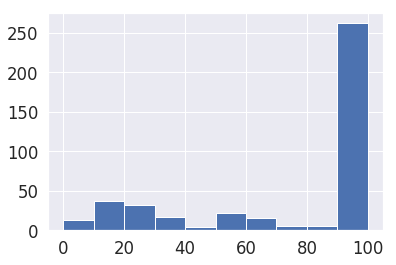

In [0]:
plt.hist(lp)

In [0]:
over_df.columns

Index(['id', 'name', 'hour', 'weekday', 'datetime'], dtype='object')

###找出項目負責人

###找出實際完成時間=FinalDateTime

###估計工作天數(DuteDateTime - StartDateTime)

###實際工作天數(FinalDateTime - StartDateTime)

In [0]:
todo_ids=todo_finished['ID']

account_id_ls=[]#負責人AccountID(String)
group_id_ls=[]#群組ID(String)
role_3_ls=[]#審核人個數(Integer)
role_4_ls=[]#參與人個數(Integer)
role_M_ls=[]#管理人個數(Integer)
modify_duedate_times_ls=[]#變更截止時間次數(Integer)
modify_worker_times_ls=[]#變更負責人次數(Integer)
modify_progress_times_ls=[]#更新進度次數(Integer)
last_progress_ls=[]#最後一次更新進度(Integer)
working_hours_ls=[]#估計工作時數(Integer)
actual_working_hours_ls=[]#實際工作時數(Integer)
working_days_ls=[]#估計工作天數(float)
actual_working_days_ls=[]#實際工作天數(float)
is_work_over_times_ls=[]#加班次數(Integer)

diff_day_ls=[]

for tid in todo_ids:
  d=todo_finished[todo_finished.ID==tid]
  group_id=d['GroupID'].iloc[0]
  parane_todo_id=d['ParentToDoID'].iloc[0]
  reply_df_s=reply_df[reply_df.ID==tid]
  
  c_member=member_df[member_df.ID==tid]
  p_member=member_df[member_df.ID==parane_todo_id]
  
  role_1=c_member[c_member.RoleType=='1']
  role_3=c_member[c_member.RoleType=='3']
  role_4=c_member[c_member.RoleType=='4']
  
  worker_account_id=role_1['AccountID'].iloc[0]
  worker_employee_id=role_1['EmployeeCode'].iloc[0]
  
  account_id_ls.append(worker_account_id)
  group_id_ls.append(group_id)
  
  role_1_count=len(role_1)#負責人
  role_3_count=len(role_3)#審核人
  role_4_count=len(role_4)#參與人
  
  role_M_count=len(p_member[p_member.RoleType=='1'])#管理人
  
  role_3_ls.append(int(role_3_count))
  role_4_ls.append(int(role_4_count))
  role_M_ls.append(int(role_M_count))
  
  if(role_3_count>0):
    comments=reply_df_s[reply_df_s['Comment'].str.contains('已通過項目的驗收')]
    finish_time=comments['PostedDate'].iloc[len(comments)-1]
    
    final_date_obj = datetime.datetime.strptime(finish_time[:19], '%Y-%m-%dT%H:%M:%S')
    #print('PostedDate: ',finish_time)
  else:
    finish_time=d['ProgressUpdateTime'].iloc[0]
    final_date_obj = datetime.datetime.strptime(finish_time, '%Y-%m-%dT%H:%M:%S.%f')
    #print('ProgressUpdateTime: ',finish_time)
    
  comments=reply_df_s[reply_df_s['Comment'].str.contains('變更了截止時間')]
  modify_duedate_times=len(comments)
  modify_duedate_times_ls.append(int(modify_duedate_times))
  #print('變更截止時間次數:',modify_duedate_times)

  comments=reply_df_s[reply_df_s['Comment'].str.contains('將負責人由')]
  modify_worker_times=len(comments)
  modify_worker_times_ls.append(int(modify_worker_times))
  #print('變更負責人次數:',modify_worker_times)

  comments=reply_df_s[reply_df_s['Comment'].str.contains('更新了進度')]
  modify_progress_times=len(comments)
  modify_progress_times_ls.append(int(modify_progress_times))
  #print('更新了進度次數:',modify_progress_times)

  last_progress=d['LastProgress'].iloc[0]
  last_progress_ls.append(int(last_progress))

  start_date=d['StartDateTime'].iloc[0]
  due_date=d['DueDateTime'].iloc[0]
  start_date_obj = datetime.datetime.strptime(start_date, '%Y-%m-%dT%H:%M:%S')
  due_date_obj = datetime.datetime.strptime(due_date, '%Y-%m-%dT%H:%M:%S')
  
  
  diff1=due_date_obj-start_date_obj
  diff2=final_date_obj-start_date_obj
  
  #one day = 86400s
  diff1InDays=(diff1.total_seconds() / 86400)#估計完成天數
  diff2InDays=(diff2.total_seconds() / 86400)#實際完成天數
  diff1InHours=(diff1.total_seconds() / 3600)#估計完成時數
  diff2InHours=(diff2.total_seconds() / 3600)#實際完成時數
  
  if(diff2InDays<=0):
    print(d['Title'])
    print(d['StartDateTime'])
    print(d['ProgressUpdateTime'])
    print('final_date_obj: ',final_date_obj)
    print('start_date_obj: ',start_date_obj)

  
  working_hours_ls.append(diff1InHours)
  actual_working_hours_ls.append(diff2InHours)
  working_days_ls.append(diff1InDays)
  actual_working_days_ls.append(diff2InDays)
  
  diff_day_ls.append((diff1InDays-diff2InDays))
  
  #加班與否
  worker_attend=over_df[over_df.id==worker_employee_id]
  #print(len(worker_attend))
  is_work_over_times=0
  for i,dateString in enumerate(worker_attend['datetime']):
    a_date=datetime.datetime.strptime(dateString, '%Y-%m-%d %H:%M:%S.%f')
    if(a_date>start_date_obj and final_date_obj>a_date):
      is_work_over_times=is_work_over_times+1
      
  is_work_over_times_ls.append(is_work_over_times)
  #print('is_work_over_times=',is_work_over_times)



(array([  1.,   3.,   0.,   6.,  19., 168., 201.,   9.,   3.,   2.]),
 array([-47.98428241, -40.17259014, -32.36089786, -24.54920559,
        -16.73751332,  -8.92582105,  -1.11412878,   6.6975635 ,
         14.50925577,  22.32094804,  30.13264031]),
 <a list of 10 Patch objects>)

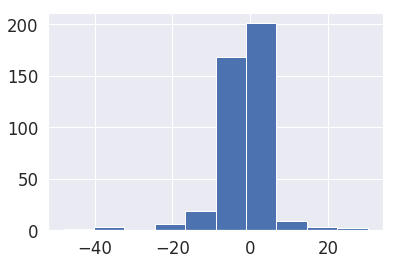

In [0]:
plt.hist(diff_day_ls)

In [0]:
print(np.max(diff_day_ls))
print(np.min(diff_day_ls))

30.132640312499998
-47.984282407407406


(array([128., 106., 109.,  22.,  12.,  13.,   8.,   6.,   0.,   8.]),
 array([-0.425     ,  5.86333218, 12.15166435, 18.43999653, 24.7283287 ,
        31.01666088, 37.30499306, 43.59332523, 49.88165741, 56.16998958,
        62.45832176]),
 <a list of 10 Patch objects>)

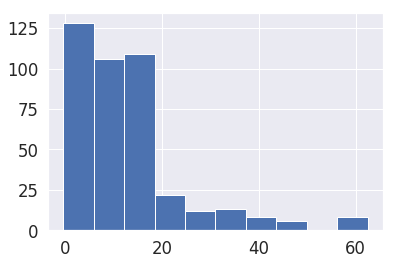

In [0]:
plt.hist(working_days_ls)

(array([144., 144.,  70.,  18.,  18.,   9.,   1.,   4.,   1.,   3.]),
 array([4.64004630e-04, 8.23320117e+00, 1.64659383e+01, 2.46986755e+01,
        3.29314127e+01, 4.11641498e+01, 4.93968870e+01, 5.76296242e+01,
        6.58623613e+01, 7.40950985e+01, 8.23278356e+01]),
 <a list of 10 Patch objects>)

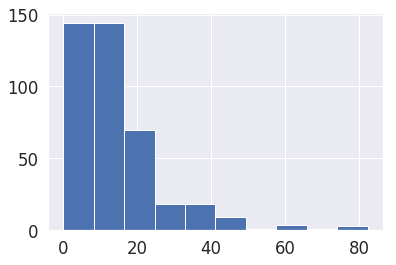

In [0]:
plt.hist(actual_working_days_ls)

###文字資料-Title,一般留言,系統留言

In [0]:
jieba.load_userdict('/content/todo_prediction/dict.txt')

In [0]:
output = open('text_source.txt', 'w', encoding='utf-8')

In [0]:
title_txt=out_df['Title'].unique()
group_name_txt=out_df['GroupName'].unique()
comment_txt=reply_df['Comment'].unique()

In [0]:
print(len(out_df['GroupName']))
print(len(out_df['GroupName'].unique()))
print(len(out_df['Title']))
print(len(out_df['Title'].unique()))
print(len(reply_df['Comment']))
print(len(reply_df['Comment'].unique()))

742
34
742
686
7526
3229


In [0]:
for tt in title_txt:
  seg_list = jieba.cut(tt, cut_all=False)
  output.write(" ".join(seg_list))
  output.write('\n')
for gn in group_name_txt:
  seg_list = jieba.cut(gn, cut_all=False)
  output.write(" ".join(seg_list))
  output.write('\n')
for ct in comment_txt:
  seg_list = jieba.cut(ct, cut_all=False)
  output.write(" ".join(seg_list))
  output.write('\n')
  
output.close()

In [0]:
sentences = word2vec.LineSentence("text_source.txt")
model = word2vec.Word2Vec(sentences, window=5, min_count=5, size=300, sg=0, workers=32, hs=1, iter=5)
model.save("word2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#print (model['通知'])
print (model.most_similar("解鎖"))

[('chat', 0.8330261707305908), ('19L005', 0.8258754014968872), ('刪', 0.8123999834060669), ('111', 0.8076339960098267), ('負責人', 0.8013292551040649), ('人', 0.7993761301040649), ('即', 0.791107714176178), ('指定', 0.7846459150314331), ('Flow', 0.7821053266525269), ('#', 0.776099443435669)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
todo_finished.columns

Index(['ID', 'Title', 'AccountID', 'Username', 'DisplayName', 'TodoStatus',
       'GroupID', 'GroupName', 'GroupEnabled', 'GroupLevel', 'RootToDoID',
       'ParentToDoID', 'ParentAccountID', 'Progress', 'LastProgress',
       'AlertType', 'ProgressUpdateTime', 'Description', 'HasDueTime',
       'CreatedDateTime', 'LastUpdatedDateTime', 'StartDateTime',
       'DueDateTime'],
      dtype='object')

In [0]:
reply_df.columns

Index(['ID', 'Title', 'PostAccount', 'Username', 'DisplayName', 'CommentID',
       'MessageID', 'ParentID', 'PostType', 'MessageStatus', 'IsReply',
       'RestrictType', 'RestrictAccounts', 'Liking', 'LikeCount', 'PostedDate',
       'Comment'],
      dtype='object')

In [0]:
#Comment
#reply_df['Comment']
rrc=pd.DataFrame({'PostType':reply_df['PostType'],'Comment':reply_df['Comment']})
rrc[reply_df.PostType=='0']

,PostType,Comment
7,0,整體驗完成，待雙平台完成後，一起上線，
9,0,列入20190313 release，已上線。
11,0,ios FCM 移轉， 3/13 上線，android FCM 移轉預訂於 3/18 上線。
14,0,列入 20190318 release，已上線。
16,0,請準備測機二台，明天提供給我進行驗證。
282,0,Ok
284,0,驗證階段
285,0,#19L001 回覆功能Bar的+延伸功能新增評分入口(已於1108群組頁面更新)\nJ\n...
286,0,0220已上線了？
287,0,列入 20190220 release


#模型訓練

In [0]:
from sklearn import preprocessing

role_3_scaled=preprocessing.minmax_scale(role_3_ls,axis=0,feature_range=(0, 1))
role_4_scaled=preprocessing.minmax_scale(role_4_ls,axis=0,feature_range=(0, 1))
role_M_scaled=preprocessing.minmax_scale(role_M_ls,axis=0,feature_range=(0, 1))
modify_duedate_times_scaled=preprocessing.minmax_scale(modify_duedate_times_ls,axis=0,feature_range=(0, 1))
modify_worker_times_scaled=preprocessing.minmax_scale(modify_worker_times_ls,axis=0,feature_range=(0, 1))
modify_progress_times_scaled=preprocessing.minmax_scale(modify_progress_times_ls,axis=0,feature_range=(0, 1))
last_progress_scaled=preprocessing.minmax_scale(last_progress_ls,axis=0,feature_range=(0, 1))
is_work_over_times_scaled=preprocessing.minmax_scale(is_work_over_times_ls,axis=0,feature_range=(0, 1))
working_days_scaled=preprocessing.minmax_scale(working_days_ls,axis=0,feature_range=(0, 1))

In [0]:
df=pd.DataFrame({
'TODO_ID':todo_ids,
'負責人':account_id_ls,
'群組ID':group_id_ls,
'審核人數':role_3_scaled,
'參與人數':role_4_scaled,
'管理人數':role_M_scaled,
'變更截止時間次數':modify_duedate_times_scaled,
'變更負責人次數':modify_worker_times_scaled,
'更新進度次數':modify_progress_times_scaled,
'最後一次更新進度':last_progress_scaled,
'加班次數':is_work_over_times_scaled,
'估計工作天數':working_days_scaled,
'實際工作天數':actual_working_days_ls})

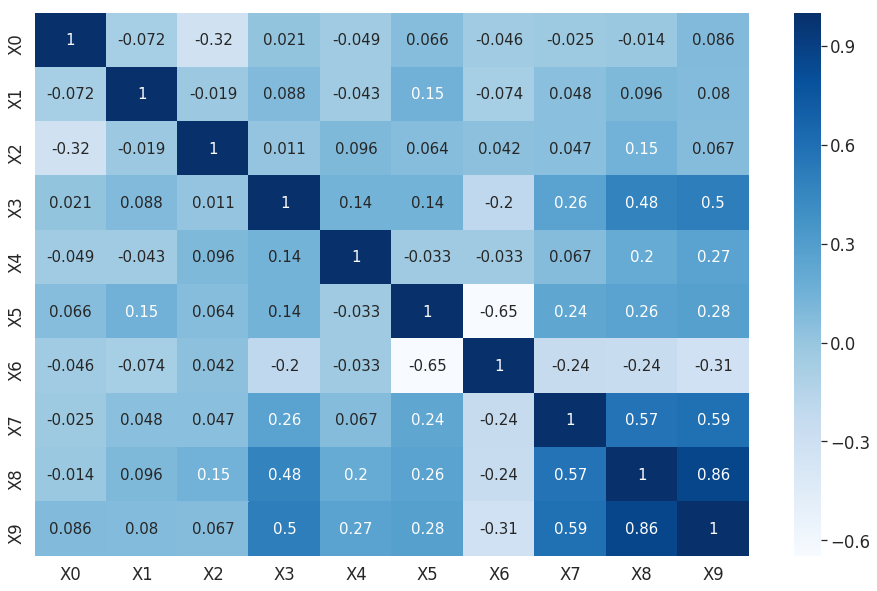

In [0]:
fig = plt.gcf()
fig.set_size_inches( 16, 10)
corr=df.corr()
sns.set(font_scale=1.5,font='sans-serif')
sns.heatmap(corr, cmap='Blues', annot=True, annot_kws={"size": 15},
            xticklabels=['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9'],
            yticklabels=['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']);

# X0 = '審核人數'
# X1 = '參與人數'
# X2 = '管理人數'
# X3 = '變更截止時間次數'
# X4 = '變更負責人次數'
# X5 = '更新進度次數'
# X6 = '最後一次更新進度'
# X7 = '加班次數'
# X8 = '估計工作天數'
# X9 = '實際工作天數'

In [0]:
cols=[
'負責人',
'群組ID',
'審核人數',
'參與人數',
'管理人數',
'變更截止時間次數',
'變更負責人次數',
'更新進度次數',
'最後一次更新進度',
'加班次數',
'估計工作天數',
]
data=df[cols]
target=df['實際工作天數']
todo_id=df['TODO_ID']
measure=working_days_ls

In [0]:
print(len(data))
print(len(target))
print(len(todo_id))
print(len(measure))

412
412
412
412


In [0]:
df.head()

,TODO_ID,負責人,群組ID,審核人數,參與人數,管理人數,變更截止時間次數,變更負責人次數,更新進度次數,最後一次更新進度,加班次數,估計工作天數,實際工作天數
1,12205,3718,1591,0.0,0.0,1.0,0.000000,0.333333,0.2,0.15,0.0,0.907545,41.088602
2,12206,2457,1591,0.0,0.0,1.0,0.333333,0.000000,0.1,1.00,0.0,0.907545,41.154646
4,12208,2443,1591,0.0,0.0,0.5,0.000000,0.000000,0.1,1.00,0.0,0.223330,13.957125
5,12209,2443,1591,0.0,0.0,0.5,0.000000,0.000000,0.1,1.00,0.0,0.223319,13.969728
6,12210,2443,1591,0.0,0.0,0.5,0.000000,0.000000,0.1,1.00,0.0,0.334625,26.341257


In [0]:
df.groupby('負責人').size()

負責人
1       10
11       3
1989     9
2193    22
2443    18
2457    44
2702    12
2727     8
2757    16
3014    30
3052    42
3126     1
3162     1
3174    46
3301    57
3539    13
3707     7
3718    59
4409     4
960     10
dtype: int64

In [0]:
print(df['負責人'].unique())
print(type(df.groupby('負責人').size()))

['3718' '2457' '2443' '2702' '2757' '3707' '3162' '3014' '960' '3539'
 '3174' '3052' '3301' '2727' '1' '11' '2193' '3126' '1989' '4409']
<class 'pandas.core.series.Series'>


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 1 to 722
Data columns (total 13 columns):
TODO_ID     412 non-null object
負責人         412 non-null object
群組ID        412 non-null object
審核人數        412 non-null float64
參與人數        412 non-null float64
管理人數        412 non-null float64
變更截止時間次數    412 non-null float64
變更負責人次數     412 non-null float64
更新進度次數      412 non-null float64
最後一次更新進度    412 non-null float64
加班次數        412 non-null float64
估計工作天數      412 non-null float64
實際工作天數      412 non-null float64
dtypes: float64(10), object(3)
memory usage: 45.1+ KB


In [0]:
data=pd.get_dummies(data)
data.head()

,審核人數,參與人數,管理人數,變更截止時間次數,變更負責人次數,更新進度次數,最後一次更新進度,加班次數,估計工作天數,負責人_1,負責人_11,負責人_1989,負責人_2193,負責人_2443,負責人_2457,負責人_2702,負責人_2727,負責人_2757,負責人_3014,負責人_3052,負責人_3126,負責人_3162,負責人_3174,負責人_3301,負責人_3539,負責人_3707,負責人_3718,負責人_4409,負責人_960,群組ID_1246,群組ID_1591,群組ID_1655,群組ID_2058,群組ID_2422,群組ID_2502,群組ID_2509,群組ID_2554,群組ID_948,群組ID_949,群組ID_999
1,0.0,0.0,1.0,0.000000,0.333333,0.2,0.15,0.0,0.907545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.333333,0.000000,0.1,1.00,0.0,0.907545,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.5,0.000000,0.000000,0.1,1.00,0.0,0.223330,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0.0,0.0,0.5,0.000000,0.000000,0.1,1.00,0.0,0.223319,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.5,0.000000,0.000000,0.1,1.00,0.0,0.334625,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, id_train, id_test, ms_train, ms_test  = train_test_split(data, target,todo_id,measure,test_size = 0.2,random_state = 40)

In [0]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(len(id_train))
print(len(id_test))
print(len(ms_train))
print(len(ms_test))

329
83
329
83
329
83
329
83


In [0]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [0]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
#print("RMSE : ",sqrt(mean_squared_log_error(y_test,y_pred)))
print("RMSE : ",sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score : ",r2)

RMSE :  5.8791057544326355
R2 Score :  0.8034672361397704


In [0]:
from sklearn import svm
clf = svm.SVR(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("RMSE : ",sqrt(mean_squared_log_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score : ",r2)

RMSE :  0.8746074561088334
R2 Score :  0.050777106468193556


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=3, random_state=37, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE : ",sqrt(mean_squared_log_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score : ",r2)

RMSE :  0.5102583556237167
R2 Score :  0.7554419988295326


In [0]:
import xgboost
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.06, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
print("RMSE : ",sqrt(mean_squared_log_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score : ",r2)

[07:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.4348163823395584
R2 Score :  0.7963350753433229


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
idd=todo_df[todo_df.ID.isin(id_test)]
idd

,ID,Title,AccountID,Username,DisplayName,TodoStatus,GroupID,GroupName,GroupEnabled,GroupLevel,RootToDoID,ParentToDoID,ParentAccountID,Progress,LastProgress,AlertType,ProgressUpdateTime,Description,HasDueTime,CreatedDateTime,LastUpdatedDateTime,StartDateTime,DueDateTime
5,12209,Android 貼文回覆延申 bar U,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-15T00:26:24.507,,0,2019-02-01T01:10:26.557,2019-02-22T01:44:20.657,2019-02-01T01:10:00,2019-02-14T15:59:59
6,12210,iOS 通知迷航,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-27T09:22:24.640,,0,2019-02-01T01:11:01.293,2019-02-27T09:22:27.280,2019-02-01T01:11:00,2019-02-21T15:59:59
9,12223,搜索工作,2193,hsiangyulin,Hsiangyu Lin,1,1591,APD每週例會報告,1,6,12062,12062,2193,100,14,1,2019-03-28T05:59:04.437,,0,2019-02-14T02:57:17.490,2019-03-28T07:15:10.427,2019-02-14T02:57:00,2019-03-29T15:59:59
15,12230,#4198 調整出差申請流程,960,lily,Lily Chou,1,1591,APD每週例會報告,1,6,12086,12086,960,100,100,1,2019-02-14T15:38:19.580,,1,2019-02-14T13:40:17.037,2019-02-14T23:10:13.860,2019-02-14T13:40:00,2019-02-15T04:00:00
18,12233,GamaFlow轉移,960,lily,Lily Chou,1,1591,APD每週例會報告,1,6,12086,12086,960,100,3,1,2019-03-29T08:49:05.703,,1,2019-02-14T13:52:47.317,2019-04-03T09:49:58.073,2019-02-14T13:52:00,2019-04-03T10:00:00
20,12235,TFS的測試環境建置,960,lily,Lily Chou,1,1591,APD每週例會報告,1,6,12234,12234,960,100,60,1,2019-03-07T12:10:34.330,,1,2019-02-14T15:34:51.797,2019-03-07T12:57:38.797,2019-02-14T15:34:00,2019-02-22T10:00:00
25,12240,Android #19L006,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-03-01T04:18:37.417,,0,2019-02-15T00:30:59.843,2019-03-07T01:43:29.590,2019-02-15T00:30:00,2019-02-21T15:59:59
33,12248,ios #19U005,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-21T03:53:28.597,,0,2019-02-15T00:51:08.590,2019-03-29T05:38:53.280,2019-02-15T00:51:00,2019-02-20T15:59:59
54,12275,#19L015,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12274,12274,2443,100,20,1,2019-03-29T07:47:12.070,,0,2019-02-21T01:46:45.433,2019-03-30T02:31:24.790,2019-02-21T01:46:00,2019-03-29T15:59:59
55,12276,#19L013,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12274,12274,2443,100,85,1,2019-03-08T01:49:57.573,,0,2019-02-21T01:47:48.523,2019-03-08T03:28:27.690,2019-02-21T01:47:00,2019-02-27T15:59:59


#模型驗證

In [0]:
count=0
for i,wd in enumerate(y_test):
  m=(y_pred[i]-wd)/wd
  if(abs(m)<=0.2):
    count=count+1
    print('實際=',wd,' 預測=',y_pred[i])

print('Total:=',len(y_test))
print('誤差小於20%天數= ',count)

實際= 12.087928240740741  預測= 14.093607
實際= 4.003067129629629  預測= 3.3273585
實際= 9.225462962962963  預測= 9.652822
實際= 21.053506944444443  預測= 21.55633
實際= 37.031527777777775  預測= 33.383118
實際= 13.030208333333333  預測= 13.126435
實際= 13.969728090277778  預測= 11.774258
實際= 9.869375  預測= 11.4699745
實際= 16.86076388888889  預測= 17.16777
實際= 13.469814814814814  預測= 12.967409
實際= 82.32783564814815  預測= 79.137115
實際= 15.07045138888889  預測= 16.041473
實際= 10.221863425925926  預測= 10.936102
實際= 14.844212962962963  預測= 16.247334
實際= 29.391597222222224  預測= 24.113695
實際= 7.00559880787037  預測= 7.0743017
實際= 24.43223480324074  預測= 28.911793
實際= 38.30952546296297  預測= 41.781017
實際= 13.465266203703704  預測= 13.266131
實際= 14.082604166666666  預測= 14.523558
實際= 29.019444444444446  預測= 33.506466
實際= 31.049351851851853  預測= 32.71007
實際= 8.019594907407408  預測= 7.6623616
實際= 13.816967592592592  預測= 15.893771
實際= 14.844236111111112  預測= 14.657066
實際= 9.216932870370371  預測= 9.361401
實際= 9.216712962962964  預測= 9.361401
實

In [0]:
count=0
id_ls=[]
for i,wd in enumerate(y_test):
  m=(y_pred[i]-wd)/wd
  if(abs(m)>=0.5):
    count=count+1
    id_ls.append(id_test.iloc[i])
    print('實際=',wd,' 預測=',y_pred[i], '  TODO_ID=', id_test.iloc[i])

print('誤差大於50%天數= ',count)

實際= 6.126719872685185  預測= 11.655335   TODO_ID= 12248
實際= 1.1299421296296297  預測= 3.48491   TODO_ID= 13048
實際= 24.789357025462966  預測= 10.189891   TODO_ID= 12332
實際= 3.651273148148148  預測= 6.641911   TODO_ID= 13067
實際= 5.551793981481482  預測= 8.347822   TODO_ID= 12792
實際= 5.523055555555556  預測= 8.518173   TODO_ID= 13378
實際= 11.075150462962963  預測= 3.6540287   TODO_ID= 12355
實際= 5.9086689814814815  預測= 9.408441   TODO_ID= 13027
實際= 0.473580787037037  預測= 7.0481586   TODO_ID= 13154
實際= 6.184039351851852  預測= 15.646463   TODO_ID= 12969
實際= 5.551967592592592  預測= 8.347822   TODO_ID= 12793
實際= 7.351720914351852  預測= 11.510753   TODO_ID= 13090
實際= 41.02162758101852  預測= 6.706754   TODO_ID= 12485
實際= 8.098357835648148  預測= 2.6605446   TODO_ID= 13139
實際= 1.2237384259259259  預測= 2.0798614   TODO_ID= 12921
實際= 10.502777777777778  預測= 16.129288   TODO_ID= 13379
實際= 1.2280208333333333  預測= 1.9396911   TODO_ID= 12920
實際= 2.603853275462963  預測= 0.6190516   TODO_ID= 13013
實際= 17.681921296296295  預測= 5

In [0]:
todo_df[todo_df.ID.isin(id_ls)]

,ID,Title,AccountID,Username,DisplayName,TodoStatus,GroupID,GroupName,GroupEnabled,GroupLevel,RootToDoID,ParentToDoID,ParentAccountID,Progress,LastProgress,AlertType,ProgressUpdateTime,Description,HasDueTime,CreatedDateTime,LastUpdatedDateTime,StartDateTime,DueDateTime
20,12235,TFS的測試環境建置,960,lily,Lily Chou,1,1591,APD每週例會報告,1,6,12234,12234,960,100,60,1,2019-03-07T12:10:34.330,,1,2019-02-14T15:34:51.797,2019-03-07T12:57:38.797,2019-02-14T15:34:00,2019-02-22T10:00:00
33,12248,ios #19U005,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12207,12207,2443,100,100,1,2019-02-21T03:53:28.597,,0,2019-02-15T00:51:08.590,2019-03-29T05:38:53.280,2019-02-15T00:51:00,2019-02-20T15:59:59
66,12291,評分進串流,2193,hsiangyulin,Hsiangyu Lin,1,1591,APD每週例會報告,1,6,12062,12062,2193,100,10,1,2019-02-22T09:20:16.967,,0,2019-02-21T10:46:51.200,2019-03-11T03:07:58.900,2019-02-21T10:46:00,2019-02-22T15:59:59
81,12332,企業組織-緊急訊息,1,anguswang,Angus Wang,1,948,集團經營會議,1,6,12323,12323,16,100,10,1,2019-03-29T07:24:40.447,,0,2019-03-04T12:28:53.903,2019-03-29T07:24:45.950,2019-03-04T12:28:00,2019-03-22T15:59:59
91,12355,#4249 調整GamaFlow異常顯示,960,lily,Lily Chou,1,1591,APD每週例會報告,1,6,12086,12086,960,100,10,1,2019-03-14T11:29:09.213,,1,2019-03-07T03:22:47.440,2019-03-18T05:10:13.833,2019-03-07T03:22:00,2019-03-11T10:00:00
189,12485,名片交換地點,2193,hsiangyulin,Hsiangyu Lin,1,1591,APD每週例會報告,1,6,12062,12062,2193,100,0,1,2019-04-29T02:26:08.623,,0,2019-03-19T01:55:53.117,2019-04-29T02:26:55.613,2019-03-19T01:55:00,2019-03-22T15:59:59
192,12498,#4274 2019預算編列,960,lily,Lily Chou,1,1591,APD每週例會報告,1,6,12086,12086,960,100,100,1,2019-03-20T03:14:58.473,,1,2019-03-19T14:52:54.293,2019-03-20T05:19:11.467,2019-03-19T14:52:00,2019-03-22T10:00:00
287,12792,#19S093,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12074,12074,2443,100,100,1,2019-04-05T01:46:25.597,,0,2019-04-04T01:55:10.170,2019-04-09T15:09:36.033,2019-04-04T01:55:00,2019-04-09T15:59:59
288,12793,#19S094,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12074,12074,2443,100,100,1,2019-04-05T01:45:58.150,,0,2019-04-04T01:55:49.427,2019-04-09T15:09:50.703,2019-04-04T01:55:00,2019-04-09T15:59:59
366,12920,#19M004 IMKit SDK 更新,2443,belltseng,Bell,1,1591,APD每週例會報告,1,6,12066,12066,2443,100,100,1,2019-04-18T03:18:53.013,,0,2019-04-17T01:29:53.830,2019-04-18T06:57:21.117,2019-04-17T01:29:00,2019-04-17T15:59:59


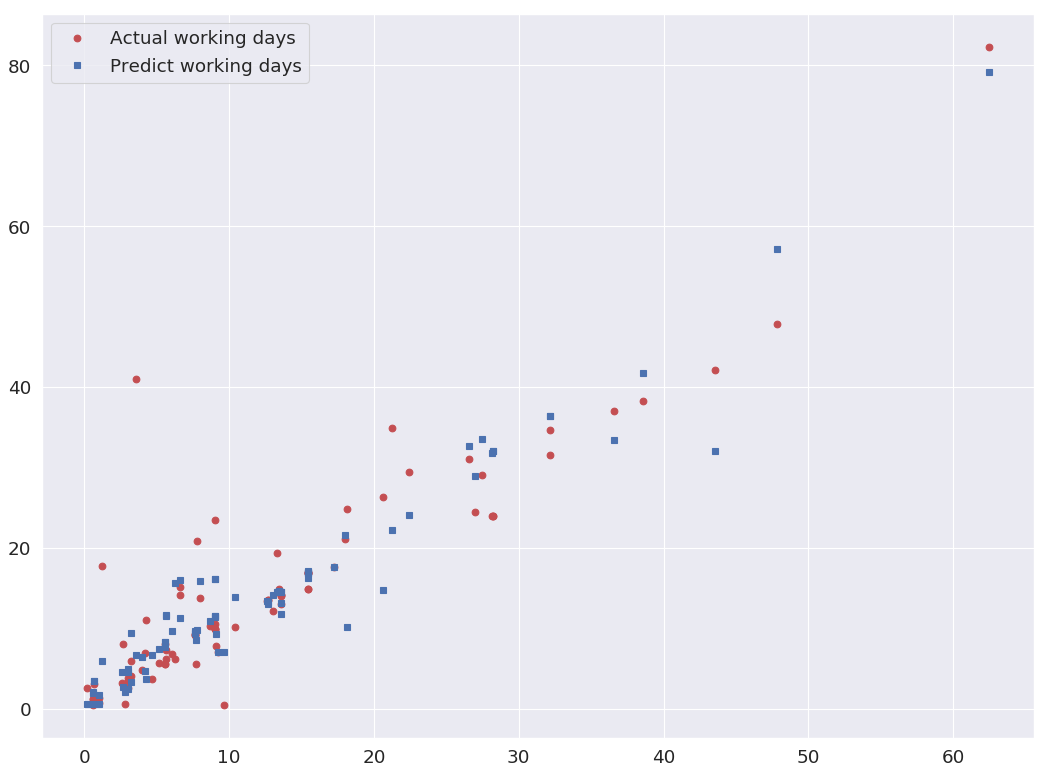

In [0]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ms_test,y_test,'ro',label='Actual working days')
plt.plot(ms_test,y_pred,'bs',label='Predict working days')
plt.legend()

In [0]:
idd.groupby('GroupName').size()

GroupName
APD每週例會報告        74
CTO teamup!       1
UI/UX(目標項目管理）     3
包租公               1
集團經營會議            4
dtype: int64

In [0]:
pred=pd.DataFrame({'TODO_ID':id_test,'y_test':y_test,'y_pred':y_pred,'ID':idd['ID'],'GroupName':idd['GroupName'],'TodoTitle':idd['Title']})
pred

,TODO_ID,y_test,y_pred,ID,GroupName,TodoTitle
5,12209,13.969728,17.051176,12209,APD每週例會報告,Android 貼文回覆延申 bar U
6,12210,26.341257,8.289695,12210,APD每週例會報告,iOS 通知迷航
9,12223,42.126440,2.737431,12223,APD每週例會報告,搜索工作
15,12230,0.395984,9.401269,12230,APD每週例會報告,#4198 調整出差申請流程
18,12233,47.831910,24.043592,12233,APD每週例會報告,GamaFlow轉移
20,12235,20.891412,4.411514,12235,APD每週例會報告,TFS的測試環境建置
25,12240,14.158766,13.531955,12240,APD每週例會報告,Android #19L006
33,12248,6.126720,22.484098,12248,APD每週例會報告,ios #19U005
54,12275,37.031528,13.296620,12275,APD每週例會報告,#19L015
55,12276,15.070451,33.834572,12276,APD每週例會報告,#19L013


In [0]:
print(type(datetime.datetime.now))
print(datetime.datetime.today())

<class 'builtin_function_or_method'>
2019-07-11 07:20:04.422664


#測試

In [0]:
apd_todo_ids=apd_todo_unfinish['ID']

account_id_ls=[]#負責人AccountID(String)
group_id_ls=[]#群組ID(String)
role_3_ls=[]#審核人個數(Integer)
role_4_ls=[]#參與人個數(Integer)
role_M_ls=[]#管理人個數(Integer)
modify_duedate_times_ls=[]#變更截止時間次數(Integer)
modify_worker_times_ls=[]#變更負責人次數(Integer)
modify_progress_times_ls=[]#更新進度次數(Integer)
last_progress_ls=[]#最後一次更新進度(Integer)
working_hours_ls=[]#估計工作時數(Integer)
working_days_ls=[]#估計工作天數(float)
is_work_over_times_ls=[]#加班次數(Integer)

diff_day_ls=[]

for tid in apd_todo_ids:
  d=apd_todo_unfinish[apd_todo_unfinish.ID==tid]
  group_id=d['GroupID'].iloc[0]
  parane_todo_id=d['ParentToDoID'].iloc[0]
  reply_df_s=reply_df[reply_df.ID==tid]
  
  c_member=member_df[member_df.ID==tid]
  p_member=member_df[member_df.ID==parane_todo_id]
  
  role_1=c_member[c_member.RoleType=='1']
  role_3=c_member[c_member.RoleType=='3']
  role_4=c_member[c_member.RoleType=='4']
  
  worker_account_id=role_1['AccountID'].iloc[0]
  worker_employee_id=role_1['EmployeeCode'].iloc[0]
  
  account_id_ls.append(worker_account_id)
  group_id_ls.append(group_id)
  
  role_1_count=len(role_1)#負責人
  role_3_count=len(role_3)#審核人
  role_4_count=len(role_4)#參與人
  
  role_M_count=len(p_member[p_member.RoleType=='1'])#管理人
  
  role_3_ls.append(int(role_3_count))
  role_4_ls.append(int(role_4_count))
  role_M_ls.append(int(role_M_count))

  comments=reply_df_s[reply_df_s['Comment'].str.contains('變更了截止時間')]
  modify_duedate_times=len(comments)
  modify_duedate_times_ls.append(int(modify_duedate_times))
  #print('變更截止時間次數:',modify_duedate_times)

  comments=reply_df_s[reply_df_s['Comment'].str.contains('將負責人由')]
  modify_worker_times=len(comments)
  modify_worker_times_ls.append(int(modify_worker_times))
  #print('變更負責人次數:',modify_worker_times)

  comments=reply_df_s[reply_df_s['Comment'].str.contains('更新了進度')]
  modify_progress_times=len(comments)
  modify_progress_times_ls.append(int(modify_progress_times))
  #print('更新了進度次數:',modify_progress_times)

  last_progress=d['LastProgress'].iloc[0]
  last_progress_ls.append(int(last_progress))

  start_date=d['StartDateTime'].iloc[0]
  due_date=d['DueDateTime'].iloc[0]
  start_date_obj = datetime.datetime.strptime(start_date, '%Y-%m-%dT%H:%M:%S')
  due_date_obj = datetime.datetime.strptime(due_date, '%Y-%m-%dT%H:%M:%S')
  
  final_date_obj=datetime.datetime.today()
  
  diff1=due_date_obj-start_date_obj
  diff2=final_date_obj-start_date_obj
  
  #one day = 86400s
  diff1InDays=(diff1.total_seconds() / 86400)#估計完成天數
  diff2InDays=(diff2.total_seconds() / 86400)#實際完成天數
  diff1InHours=(diff1.total_seconds() / 3600)#估計完成時數
  diff2InHours=(diff2.total_seconds() / 3600)#實際完成時數
  
  if(diff2InDays<=0):
    print(d['Title'])
    print(d['StartDateTime'])
    print(d['ProgressUpdateTime'])
    print('final_date_obj: ',final_date_obj)
    print('start_date_obj: ',start_date_obj)

  
  working_hours_ls.append(diff1InHours)
  working_days_ls.append(diff1InDays)
  
  #加班次數
  worker_attend=over_df[over_df.id==worker_employee_id]
  #print(len(worker_attend))
  is_work_over_times=0
  for i,dateString in enumerate(worker_attend['datetime']):
    a_date=datetime.datetime.strptime(dateString, '%Y-%m-%d %H:%M:%S.%f')
    if(a_date>start_date_obj and final_date_obj>a_date):
      is_work_over_times=is_work_over_times+1
      
  is_work_over_times_ls.append(is_work_over_times)


704    phase III - UI
Name: Title, dtype: object
704    2019-07-14T16:00:00
Name: StartDateTime, dtype: object
704    None
Name: ProgressUpdateTime, dtype: object
final_date_obj:  2019-07-11 07:20:05.131272
start_date_obj:  2019-07-14 16:00:00
705    Phase II - 後端
Name: Title, dtype: object
705    2019-07-28T16:00:00
Name: StartDateTime, dtype: object
705    None
Name: ProgressUpdateTime, dtype: object
final_date_obj:  2019-07-11 07:20:05.148081
start_date_obj:  2019-07-28 16:00:00
706    Phase III - 後端
Name: Title, dtype: object
706    2019-08-11T16:00:00
Name: StartDateTime, dtype: object
706    None
Name: ProgressUpdateTime, dtype: object
final_date_obj:  2019-07-11 07:20:05.162244
start_date_obj:  2019-08-11 16:00:00


In [0]:
role_3_scaled=preprocessing.minmax_scale(role_3_ls,axis=0,feature_range=(0, 1))
role_4_scaled=preprocessing.minmax_scale(role_4_ls,axis=0,feature_range=(0, 1))
role_M_scaled=preprocessing.minmax_scale(role_M_ls,axis=0,feature_range=(0, 1))
modify_duedate_times_scaled=preprocessing.minmax_scale(modify_duedate_times_ls,axis=0,feature_range=(0, 1))
modify_worker_times_scaled=preprocessing.minmax_scale(modify_worker_times_ls,axis=0,feature_range=(0, 1))
modify_progress_times_scaled=preprocessing.minmax_scale(modify_progress_times_ls,axis=0,feature_range=(0, 1))
last_progress_scaled=preprocessing.minmax_scale(last_progress_ls,axis=0,feature_range=(0, 1))
is_work_over_times_scaled=preprocessing.minmax_scale(is_work_over_times_ls,axis=0,feature_range=(0, 1))
working_days_scaled=preprocessing.minmax_scale(working_days_ls,axis=0,feature_range=(0, 1))

df=pd.DataFrame({
'TODO_ID':apd_todo_ids,
'負責人':account_id_ls,
'群組ID':group_id_ls,
'審核人數':role_3_scaled,
'參與人數':role_4_scaled,
'管理人數':role_M_scaled,
'變更截止時間次數':modify_duedate_times_scaled,
'變更負責人次數':modify_worker_times_scaled,
'更新進度次數':modify_progress_times_scaled,
'最後一次更新進度':last_progress_scaled,
'加班次數':is_work_over_times_scaled,
'估計工作天數':working_days_scaled})

cols=[
'負責人',
'群組ID',
'審核人數',
'參與人數',
'管理人數',
'變更截止時間次數',
'變更負責人次數',
'更新進度次數',
'最後一次更新進度',
'加班次數',
'估計工作天數',
]
data=df[cols]
todo_id=df['TODO_ID']
#measure=working_days_ls

In [0]:
data=pd.get_dummies(data)
data.head()

,審核人數,參與人數,管理人數,變更截止時間次數,變更負責人次數,更新進度次數,最後一次更新進度,加班次數,估計工作天數,負責人_11,負責人_1989,負責人_2193,負責人_2443,負責人_2457,負責人_2702,負責人_2727,負責人_2757,負責人_3014,負責人_3052,負責人_3126,負責人_3174,負責人_3301,負責人_3539,負責人_3707,負責人_3718,負責人_4409,負責人_960,群組ID_1591
11,1.0,0.0,0.333333,0.50,0.0,0.333333,0.1,0.604651,0.803876,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
124,1.0,0.0,0.000000,0.25,0.0,0.000000,0.0,0.511628,0.337856,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
196,1.0,0.0,0.333333,0.25,0.0,0.000000,0.0,0.651163,0.486258,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
197,1.0,0.0,0.333333,0.00,0.0,0.000000,0.0,1.000000,0.185759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
198,1.0,0.0,0.333333,0.00,0.0,0.000000,0.0,1.000000,0.259647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [0]:
#RandamForest
y_pred = rf.predict(data)
predic_df=pd.DataFrame({'TODO_ID':todo_id,'Working days prediction':y_pred})
predic_df.head(10)